In [21]:
# Import dependencies
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
# Import data
v0_df = pd.read_csv('../python_etl_processing/v0_df.csv')

In [3]:
# Create 'serious flag' for outcome - if an accident was fatal or had a serious injury
v0_df['serious_fl'] = v0_df.apply(lambda row: 1 if row['crash_fatal_fl'] == 1 or row['sus_serious_injry_cnt'] == 1 else 0, axis=1)

In [4]:
# Separate out date column
v0_df['year'] = pd.DatetimeIndex(v0_df['crash_date']).year
v0_df['month'] = pd.DatetimeIndex(v0_df['crash_date']).month
v0_df['day'] = pd.DatetimeIndex(v0_df['crash_date']).day
v0_df['crash_time'] = pd.to_datetime(v0_df['crash_time'])
v0_df['hour'] = pd.DatetimeIndex(v0_df['crash_time']).hour

In [5]:
# Import population csv
pop_df = pd.read_csv('../python_etl_processing/austin_pop.csv')

In [6]:
merged_df = v0_df.merge(pop_df, left_on="year", right_on="Year", how="left")
merged_df = merged_df.drop(columns="Year")
merged_df['year_month'] = merged_df['year'].astype(str) + "_" + merged_df['month'].astype(str)
merged_df.head()

,crash_id,crash_fatal_fl,crash_date,crash_time,crash_speed_limit,road_constr_zone_fl,latitude,longitude,crash_sev_id,sus_serious_injry_cnt,...,other_death_count,other_serious_injury_count,serious_fl,year,month,day,hour,Population,Growth Rate,year_month
0,"12,992,764",0,2012-11-06,2022-10-27 04:51:00,65.0,0.0,30.377406,-97.734442,3,0,...,0,0,0,2012,11,6,4,1495000,0.0425,2012_11
1,"12,979,184",0,2012-10-27,2022-10-27 05:01:00,0.0,0.0,30.421736,-97.665935,0,0,...,0,0,0,2012,10,27,5,1495000,0.0425,2012_10
2,"12,963,865",0,2012-10-22,2022-10-27 12:42:00,30.0,0.0,30.438155,-97.785708,3,0,...,0,0,0,2012,10,22,12,1495000,0.0425,2012_10
3,"12,979,325",0,2012-10-29,2022-10-27 03:00:00,25.0,0.0,30.205650,-97.854830,5,0,...,0,0,0,2012,10,29,3,1495000,0.0425,2012_10
4,"12,979,569",0,2012-10-18,2022-10-27 02:04:00,65.0,0.0,30.417802,-97.672780,2,0,...,0,0,0,2012,10,18,2,1495000,0.0425,2012_10


In [7]:
plot_columns = ['year_month', 'serious_fl']
plot_df = merged_df[plot_columns]
plot_df = plot_df.groupby('year_month').sum()
plot_df

,serious_fl
year_month,
2012_10,20
2012_11,39
2012_12,37
2013_1,41
2013_10,42
...,...
2022_5,49
2022_6,42
2022_7,47


<AxesSubplot:xlabel='year_month'>

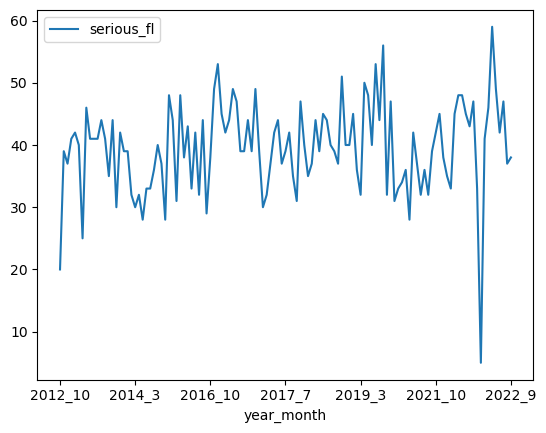

In [9]:
plot_df.plot()

In [35]:
# Get precovid data
precovid_df = merged_df[merged_df['year'] < 2020]
precovid_df = precovid_df.merge(plot_df, left_on="year_month", right_on="year_month", how="left")
precovid_df = precovid_df.rename(columns={"serious_fl_y": "total_serious"})
precovid_df = precovid_df[['year', 'month', 'day', 'hour', 'Population', 'Growth Rate', 'total_serious']]
precovid_df.head()

,year,month,day,hour,Population,Growth Rate,total_serious
0,2012,11,6,4,1495000,0.0425,39
1,2012,10,27,5,1495000,0.0425,20
2,2012,10,22,12,1495000,0.0425,20
3,2012,10,29,3,1495000,0.0425,20
4,2012,10,18,2,1495000,0.0425,20


In [36]:
# Split into X and Y
X = precovid_df.drop(columns=['total_serious'])
y = precovid_df['total_serious']

# Split into testing and training data
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Create Linear Regression model
clf = RandomForestClassifier(n_estimators=500).fit(X_train, y_train)
print(f'Training Score: {clf.score(X_train, y_train)}')
print(f'Testing Score: {clf.score(X_test, y_test)}')

Training Score: 1.0
Testing Score: 1.0


In [39]:
# Get postcovid data
covid_df = merged_df.loc[(merged_df['year'] == 2020) & (merged_df['month'] > 3) & (merged_df['month'] < 10)]
covid_df = covid_df.merge(plot_df, left_on="year_month", right_on="year_month", how="left")
covid_df = covid_df.rename(columns={"serious_fl_y": "total_serious"})
covid_df = covid_df[['year', 'month', 'day', 'hour', 'Population', 'Growth Rate', 'total_serious']]
covid_df.head()

,year,month,day,hour,Population,Growth Rate,total_serious
0,2020,4,15,0,2053000,0.0343,28
1,2020,4,8,14,2053000,0.0343,28
2,2020,4,28,17,2053000,0.0343,28
3,2020,4,4,19,2053000,0.0343,28
4,2020,4,10,2,2053000,0.0343,28


In [49]:
# Split into X and Y
X_covid = covid_df.drop(columns=['total_serious'])
y_covid = covid_df['total_serious']
month_year = covid_df['year'].astype(str) + "_" + covid_df['month'].astype(str)

# Predict using model
predictions = clf.predict(X_covid)
predict_df = pd.DataFrame({"Month": month_year, "Prediction": predictions, "Actual": y_covid})
predict_df

,Month,Prediction,Actual
0,2020_4,50,28
1,2020_4,50,28
2,2020_4,50,28
3,2020_4,50,28
4,2020_4,50,28
...,...,...,...
5138,2020_5,48,42
5139,2020_9,56,32
5140,2020_7,53,32
5141,2020_5,48,42


In [43]:
from sklearn.metrics import accuracy_score
accuracy_score(y_covid, predictions)

0.0

In [54]:
plot_covid = predict_df.drop_duplicates()
plot_covid

,Month,Prediction,Actual
0,2020_4,50,28
5,2020_5,48,42
18,2020_6,40,37
40,2020_7,53,32
53,2020_8,44,36
73,2020_9,56,32


<AxesSubplot:>

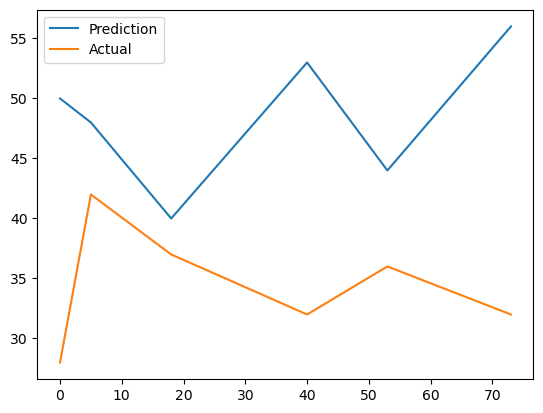

In [55]:
plot_covid.plot()